In [1]:
# Import necessary libraries

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.metrics import Precision, Recall
import tensorflow as tf
import uuid
from preprocess.proprocess import preprocess_twin, preprocess


In [2]:
# Define paths for the data
POS_PATH = os.path.join('data', 'positive')
ANC_PATH = os.path.join('data', 'anchor')
NEG_PATH = os.path.join('data', 'negative')

In [3]:
# Take 300 images from each folder
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-12-17 23:43:42.203237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Create a dataset of tuples of (anchor, positive, label)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# Create a dataset of tuples of (anchor, negative, label)
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Concatenate the two datasets
data = positives.concatenate(negatives)

## Build dataloader and partition the data into training and test set

In [7]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [8]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [9]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Construct the network

In [10]:
# Embedding layer
def make_embedding():
    """Construct the convolutional embedding network as defined in the paper.

    Returns:
        'keras.engine.functional.Functional': Embedding network.
    """
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [11]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        """ Compute the similarity of embedded input (anchor) and validation image.

        Args:
            input_embedding ('tensorflow.python.framework.ops.Tensor'): Embedded input (anchor) image.
            validation_embedding ('tensorflow.python.framework.ops.Tensor'): Embedded validation image.

        Returns:
            'tensorflow.python.framework.ops.Tensor': Similarity of given images.
        """
        return tf.math.abs(input_embedding - validation_embedding)

In [12]:
def make_siamese_model():
    """Define the complete Siamese network. 

    Returns:
        keras.engine.functional.Functional: Complete network.
    """
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    embedding = make_embedding()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [13]:
siamese_model = make_siamese_model()

In [14]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [15]:
optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

## Train the network

In [17]:
@tf.function
def train_step(batch):
    """ Train step.

    Args:
        batch ('tuple'): One batch of training data.

    Returns:
        'tensorflow.python.framework.ops.Tensor': Current loss.
    """
    binary_cross_loss = tf.losses.BinaryCrossentropy()
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [18]:
def train(data, EPOCHS):
    """ Train the network.

    Args:
        data (tensorflow.python.data.ops.dataset_ops.PrefetchDataset): Training data.
        EPOCHS (int): Number of epochs.
    """
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [19]:
# Train the network for 20 epochs
train(train_data, EPOCHS=20)


 Epoch 1/20
6/6 [==============================] - 50s 8s/step

 Epoch 2/20
6/6 [==============================] - 49s 8s/step

 Epoch 3/20
6/6 [==============================] - 50s 8s/step

 Epoch 4/20
6/6 [==============================] - 50s 8s/step

 Epoch 5/20
6/6 [==============================] - 50s 8s/step

 Epoch 6/20
6/6 [==============================] - 50s 8s/step

 Epoch 7/20
6/6 [==============================] - 50s 8s/step

 Epoch 8/20
6/6 [==============================] - 50s 8s/step

 Epoch 9/20
6/6 [==============================] - 50s 8s/step

 Epoch 10/20
6/6 [==============================] - 50s 8s/step

 Epoch 11/20
6/6 [==============================] - 50s 8s/step

 Epoch 12/20
6/6 [==============================] - 51s 8s/step

 Epoch 13/20
6/6 [==============================] - 50s 8s/step

 Epoch 14/20
6/6 [==============================] - 50s 8s/step

 Epoch 15/20
6/6 [==============================] - 50s 8s/step

 Epoch 16/20
6/6 [===============

## Save the weights and make predictions from the test set

In [20]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [21]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [22]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [23]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [24]:
y_true

array([0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

## Evaluate the model

In [25]:
# Creating a metric object 
m_recall = Recall()

# Calculating the recall value 
m_recall.update_state(y_true, y_hat)

# Return Recall Result
m_recall.result().numpy()

1.0

In [26]:
# Creating a metric object 
m_precision = Precision()

# Calculating the recall value 
m_precision.update_state(y_true, y_hat)

# Return Recall Result
m_precision.result().numpy()

1.0

## Visualize a 'true' image's classification

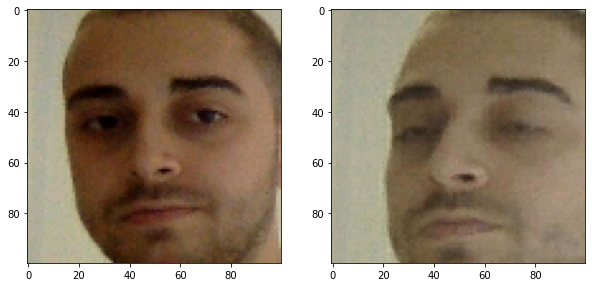

In [27]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[7])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[7])

# Renders cleanly
plt.show()

## Visualize a 'false' image's classification

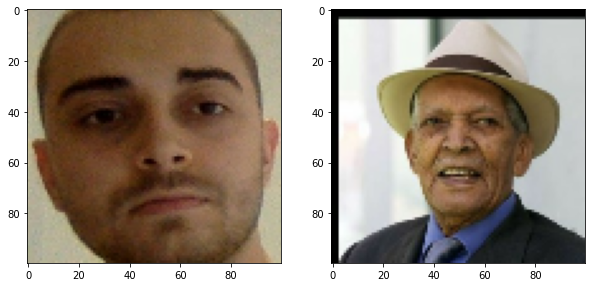

In [30]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()